In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

In [30]:
# Load the dataset
df = pd.read_csv('Diabetes-Classification.csv')  # Replace with your file path
df.dropna()
# Display dataset info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
df.head()

Dataset Shape: (128, 11)

First 5 Rows:


,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise,Diagnosis
0,45,Male,25.0,Normal,100,5.7,No,No,Healthy,Regular,No
1,55,Female,30.0,High,120,6.4,Yes,Yes,Poor,No,Yes
2,65,Male,35.0,High,140,7.1,Yes,Yes,Poor,No,Yes
3,75,Female,40.0,High,160,7.8,Yes,Yes,Poor,No,Yes
4,40,Male,20.0,Normal,80,5.0,No,No,Healthy,NaN,No


In [31]:
le = LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])
    

In [32]:
# Check column names
#print("\nColumn Names:")
#print(df.columns)

# Preprocessing
# Identify categorical and numerical columns
categorical_cols = ['Gender', 'Blood Pressure', 'Family History of Diabetes', 'Smoking', 'Diet', 'Exercise']
numerical_cols = ['Age', 'BMI', 'FBS', 'HbA1c']

# Target column
target_column = 'Diagnosis'

In [33]:
# Create a ColumnTransformer to preprocess the data in the columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols)
    ])
df.head()

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise,Diagnosis
0,19,1,8,2,1,1,0,0,0,1,0
1,25,0,11,0,2,2,1,1,1,0,1
2,31,1,14,0,3,3,1,1,1,0,1
3,34,0,17,0,4,4,1,1,1,0,1
4,16,1,5,2,0,0,0,0,0,2,0


In [34]:
# Split features and target
X = df.drop(target_column, axis=1)
y = df[target_column]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [35]:
#Balancing the Dataset (SMOTE: Oversampling using imblearn library)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [36]:
# Apply preprocessing
X_train_scaled = preprocessor.fit_transform(X_train_balanced)
X_test_scaled = preprocessor.transform(X_test)

# Convert y_train and y_test to binary (label encoding)
y_train = y_train_balanced.values
y_test = y_test.values

In [37]:
# Convert X_train_scaled and X_test_scaled to NumPy arrays (Tensorflow does not accept pandas dataframe as input, it accepts either Tensorflow tensors or NumPy arrays)
X_train_scaled = X_train_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')

In [38]:
#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input

#suppress warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Build the TensorFlow MLP model
tf_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [39]:
# Compile the model
tf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = tf_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.4448 - loss: 0.7196 - val_accuracy: 0.7500 - val_loss: 0.6823
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5085 - loss: 0.6927 - val_accuracy: 0.5714 - val_loss: 0.6912
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6213 - loss: 0.6424 - val_accuracy: 0.5714 - val_loss: 0.6913
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6594 - loss: 0.6138 - val_accuracy: 0.5714 - val_loss: 0.6947
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6726 - loss: 0.5948 - val_accuracy: 0.5714 - val_loss: 0.7026
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6838 - loss: 0.5805 - val_accuracy: 0.5714 - val_loss: 0.7077
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6496 - loss: 0.5582 - val_accuracy: 0.5714 - val_loss: 0.7118
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7033 - loss: 0.5684 - val_accuracy: 0.5714 - val_loss: 0.7082

In [40]:
# Evaluate the model
y_pred_tf = (tf_model.predict(X_test_scaled) > 0.5).astype(int)
print("\nTensorFlow MLP Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_tf))
print("Classification Report:")
print(classification_report(y_test, y_pred_tf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tf))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step

TensorFlow MLP Performance:
Accuracy: 0.5641025641025641
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67        27
           1       0.33      0.42      0.37        12

    accuracy                           0.56        39
   macro avg       0.52      0.52      0.52        39
weighted avg       0.59      0.56      0.58        39

Confusion Matrix:
[[17 10]
 [ 7  5]]


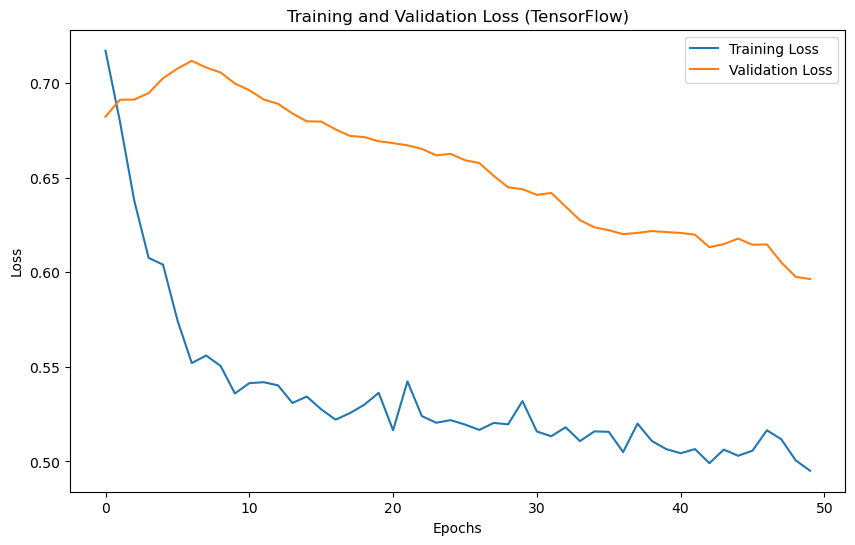

In [41]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (TensorFlow)')
plt.legend()
plt.show()

In [42]:
#Assignment: 
#Check and deal with the dataset imbalance 
#Fine-Tune the above neural network by changing the values of hyperparameters and report findings(You can use cross-validation as well)
#Use other evaluation metrics and plots to visualise performance of the model

In [43]:
#Install PyTorch from here: https://pytorch.org/get-started/locally/ (select compute platform as cpu if you dont have a gpu or doesn't have gpu drivers installed)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [44]:
# Convert the Pandas Dataframe data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [45]:
# Build the PyTorch MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

In [46]:
# Initialize the model, loss function, and optimizer
input_size = X_train_scaled.shape[1]
torch_model = MLP(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(torch_model.parameters(), lr=0.001)

In [47]:
# Train the model
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    torch_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = torch_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    torch_model.eval()
    with torch.no_grad():
        val_outputs = torch_model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}, Val Loss: {val_loss.item()}")

Epoch 1/50, Loss: 0.6791868805885315, Val Loss: 0.6925584077835083
Epoch 2/50, Loss: 0.6605893492698669, Val Loss: 0.6848862767219543
Epoch 3/50, Loss: 0.6446035623550415, Val Loss: 0.671744704246521
Epoch 4/50, Loss: 0.6249107360839844, Val Loss: 0.6594502329826355
Epoch 5/50, Loss: 0.6358115911483765, Val Loss: 0.6478566527366638
Epoch 6/50, Loss: 0.5998936772346497, Val Loss: 0.6354170441627502
Epoch 7/50, Loss: 0.5791343212127685, Val Loss: 0.6222151517868042
Epoch 8/50, Loss: 0.5810611367225647, Val Loss: 0.6142301559448242
Epoch 9/50, Loss: 0.5772870540618896, Val Loss: 0.6091340184211731
Epoch 10/50, Loss: 0.5497503638267517, Val Loss: 0.6067675948143005
Epoch 11/50, Loss: 0.5470962047576904, Val Loss: 0.6044986248016357
Epoch 12/50, Loss: 0.541707020998001, Val Loss: 0.6061669588088989
Epoch 13/50, Loss: 0.5351967215538025, Val Loss: 0.6054720282554626
Epoch 14/50, Loss: 0.526162326335907, Val Loss: 0.6081441044807434
Epoch 15/50, Loss: 0.539229691028595, Val Loss: 0.6110576391

In [48]:
# Evaluate the model
torch_model.eval()
with torch.no_grad():
    y_pred_torch = (torch_model(X_test_tensor) > 0.5).float().numpy()

print("\nPyTorch MLP Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_torch))
print("Classification Report:")
print(classification_report(y_test, y_pred_torch))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_torch))


PyTorch MLP Performance:
Accuracy: 0.5641025641025641
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.48      0.60        27
           1       0.39      0.75      0.51        12

    accuracy                           0.56        39
   macro avg       0.60      0.62      0.56        39
weighted avg       0.68      0.56      0.58        39

Confusion Matrix:
[[13 14]
 [ 3  9]]


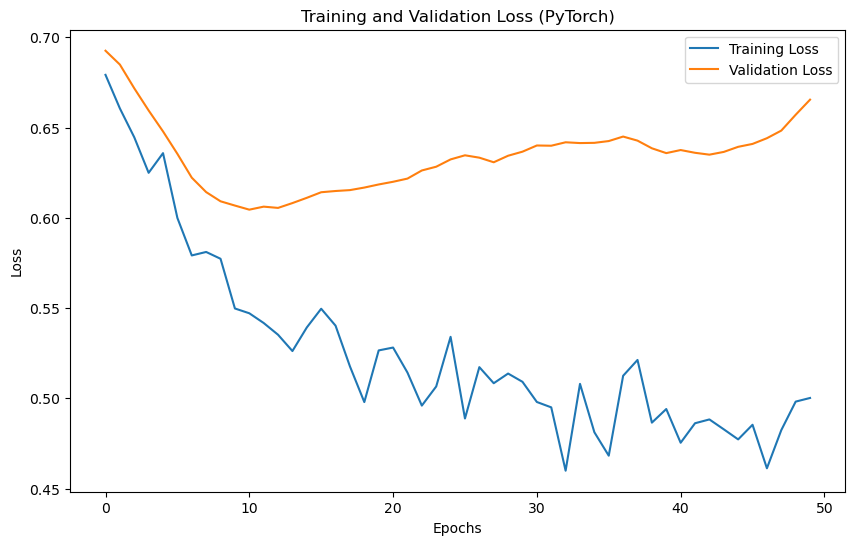

In [49]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (PyTorch)')
plt.legend()
plt.show()

In [ ]:
# Using balanced data reduced the accuracy of the mode and therefore the performance of the model. 